Transition matrix (rows sum to 1):
[[0.98708227 0.01291773]
 [0.04166358 0.95833642]]
Model converged: True
Converged in 40 iterations (tol = 0.01 )
State means: [ 0.00071555 -0.00128752]
State stds:  [0.00636463 0.0172233 ]
Bull state: 0, Bear state: 1


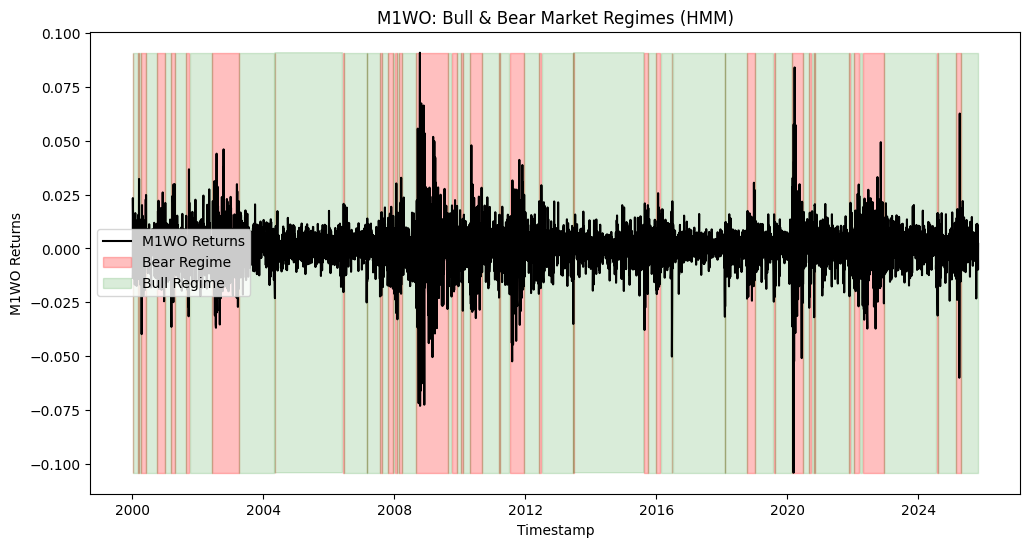

In [1]:
import pandas as pd
import numpy as np
import os, sys
sys.path.insert(0, os.path.abspath('../..'))
import source.data_handling.data_preparation as dp
import source.trading_strategies.trading_strategy as tsh
import source.plot_functions.plots_trading_strategies as plot_ts
import numpy as np
import pandas as pd
df = dp.create_classification_data(quiet=False)
df["Rfree"] = 0

In [2]:
pred_df = pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_logit.csv", index_col=0, parse_dates=True)
pred_df

/var/folders/q9/d545ygdx5rj6lg_00gpykppw0000gn/T/ipykernel_85959/568158868.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pred_df = pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_logit.csv", index_col=0, parse_dates=True)


,timestamp,y_true,y_pred,pred_prob,M1WO_O
0,2010-01-01,0,0,0.286394,2796.04
1,2010-01-04,0,0,0.318800,2846.21
2,2010-01-05,0,0,0.185114,2854.58
3,2010-01-06,0,0,0.141117,2856.52
4,2010-01-07,0,0,0.123011,2855.09
...,...,...,...,...,...
4126,2025-10-27,0,0,0.074357,14141.13
4127,2025-10-28,0,0,0.056823,14164.97
4128,2025-10-29,0,0,0.065055,14161.08
4129,2025-10-30,0,0,0.092769,14022.56


In [3]:
pred_df = pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_logit.csv", index_col=0, parse_dates=True)
bt = tsh.backtest_paper_regime_switch(
    tsh.merge_risk_free_rates(pred_df,df),
    price_col="M1WO_O",
    regime_col="y_pred",
    ts_col="timestamp",
    bear_label=1,
    rf_col="FEDL01_O",
    lag = 1
)
summary = tsh.compare_regime_strategies(bt, periods_per_year=252, gamma=5.0, benchmark="BuyHoldEq")
print(summary)

             TotalReturn      CAGR    AnnVol    Sharpe  MaxDrawdown  \
Strategy                                                              
Strategy        1.375796  0.054232  0.092805  0.468407    -0.203232   
BuyHoldEq       3.937144  0.102361  0.148428  0.639143    -0.340332   
BuyHoldRF       0.251097  0.013766  0.001110       NaN     0.000000   
Static50_50     1.600907  0.060073  0.074222  0.639143    -0.182756   

             AnnUtility  Δu vs BuyHoldEq  Δu vs HA  Δu vs 50%  Δu vs 100%  
Strategy                                                                   
Strategy       0.021939        -0.017852       NaN  -0.011724   -0.017852  
BuyHoldEq      0.039790         0.000000       NaN        NaN         NaN  
BuyHoldRF      0.000000        -0.039790       NaN        NaN         NaN  
Static50_50    0.033663        -0.006127       NaN        NaN         NaN  


/var/folders/q9/d545ygdx5rj6lg_00gpykppw0000gn/T/ipykernel_85959/3360069173.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pred_df = pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_logit.csv", index_col=0, parse_dates=True)


In [4]:
pred_df

,timestamp,y_true,y_pred,pred_prob,M1WO_O
0,2010-01-01,0,0,0.286394,2796.04
1,2010-01-04,0,0,0.318800,2846.21
2,2010-01-05,0,0,0.185114,2854.58
3,2010-01-06,0,0,0.141117,2856.52
4,2010-01-07,0,0,0.123011,2855.09
...,...,...,...,...,...
4126,2025-10-27,0,0,0.074357,14141.13
4127,2025-10-28,0,0,0.056823,14164.97
4128,2025-10-29,0,0,0.065055,14161.08
4129,2025-10-30,0,0,0.092769,14022.56


In [5]:
pred_df = pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_rf.csv", index_col=0, parse_dates=True)
bt = tsh.backtest_paper_regime_switch(
    tsh.merge_risk_free_rates(pred_df,df),
    price_col="M1WO_O",
    regime_col="y_pred",
    ts_col="timestamp",
    bear_label=1,
    rf_col="EUR003M_O"

)
summary = tsh.compare_regime_strategies(bt, periods_per_year=252, gamma=5.0, benchmark="BuyHoldEq")
print(summary)

             TotalReturn      CAGR    AnnVol    Sharpe  MaxDrawdown  \
Strategy                                                              
Strategy        1.682435  0.062056  0.097128  0.603921    -0.229012   
BuyHoldEq       4.025733  0.103532  0.148473  0.695848    -0.340332   
BuyHoldRF       0.108663  0.006314  0.000822       NaN    -0.025619   
Static50_50     1.470373  0.056733  0.074243  0.695848    -0.183473   

             AnnUtility  Δu vs BuyHoldEq  Δu vs HA  Δu vs 50%  Δu vs 100%  
Strategy                                                                   
Strategy       0.035071        -0.013133       NaN  -0.002807   -0.013133  
BuyHoldEq      0.048204         0.000000       NaN        NaN         NaN  
BuyHoldRF      0.000000        -0.048204       NaN        NaN         NaN  
Static50_50    0.037878        -0.010326       NaN        NaN         NaN  


/var/folders/q9/d545ygdx5rj6lg_00gpykppw0000gn/T/ipykernel_85959/1901960813.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pred_df = pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_rf.csv", index_col=0, parse_dates=True)


/var/folders/q9/d545ygdx5rj6lg_00gpykppw0000gn/T/ipykernel_85959/1571696974.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  "Logit": pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_logit.csv", index_col=0, parse_dates=True),
/var/folders/q9/d545ygdx5rj6lg_00gpykppw0000gn/T/ipykernel_85959/1571696974.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  "RandomForrest": pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_rf.csv", index_col=0, parse_dates=True),
/var/folders/q9/d545ygdx5rj6lg_00gpykppw0000gn/T/ipykernel_85959/1571696974.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and a

[DEBUG] Logit: 2010-01-01 00:00:00 -> 2025-10-30 00:00:00 (n=4130)
[DEBUG] RandomForrest: 2010-01-01 00:00:00 -> 2025-10-30 00:00:00 (n=4130)
[DEBUG] TabPFN-2.5: 2010-01-01 00:00:00 -> 2025-10-30 00:00:00 (n=4130)
[DEBUG] Mantis RF head: 2010-01-01 00:00:00 -> 2025-10-30 00:00:00 (n=4130)
[DEBUG] Mantis linear head: 2010-01-01 00:00:00 -> 2025-10-30 00:00:00 (n=4130)
[DEBUG] common sample: 2010-01-01 00:00:00 -> 2025-10-30 00:00:00 (n=4130)
Total return on plotted sample:
  Mantis linear head: 408.04%
  W100: 402.57%
  Mantis RF head: 399.60%
  TabPFN-2.5: 308.56%
  RandomForrest: 173.29%
  W50: 162.42%
  Logit: 135.62%
  RF: 25.11%


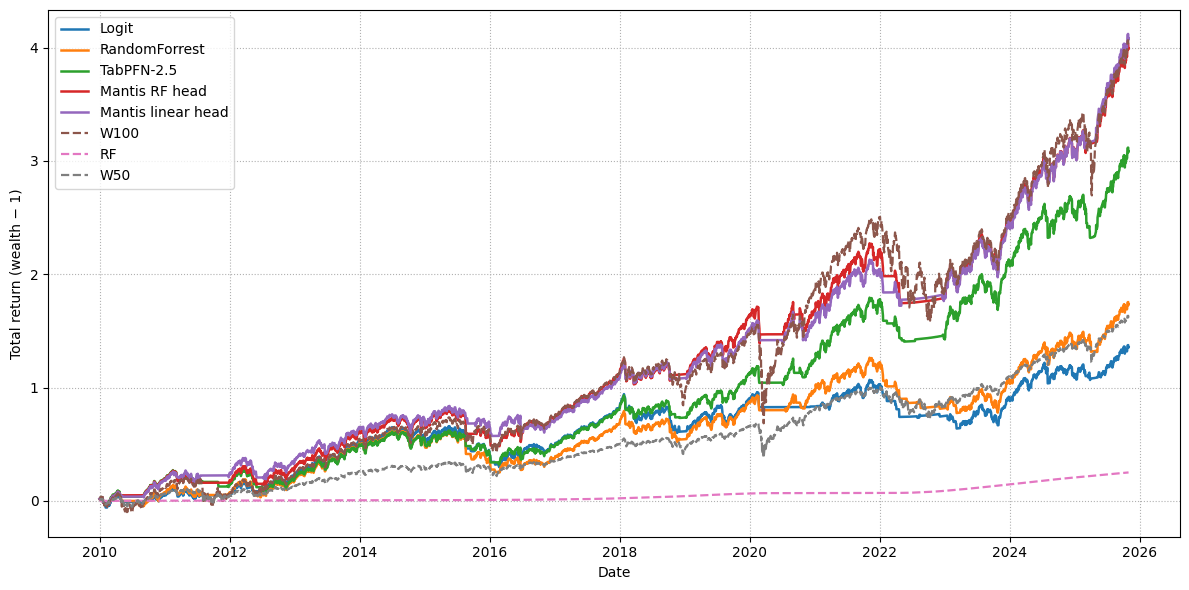

In [6]:
pred_dfs = {
    "Logit": pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_logit.csv", index_col=0, parse_dates=True),
    "RandomForrest": pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_rf.csv", index_col=0, parse_dates=True),
    "TabPFN-2.5": pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_tabpfn25.csv", index_col=0, parse_dates=True),
    "Mantis RF head": pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_mantis_rf_head.csv", index_col=0, parse_dates=True),
    "Mantis linear head": pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_mantis_head.csv", index_col=0, parse_dates=True),
}

res = plot_ts.plot_regime_models_total_return(
    pred_dfs=pred_dfs,
    df_mkt=df,
    price_col="M1WO_O",
    rf_rate_col="FEDL01_O",
    regime_col="y_pred",
    bear_label=1,
    baselines=["100", "50", "RF"],   # add "HA" if you want it
    start_date="2010-01-01",
    lag=0,
    tc_bps=0.0,
    debug=True,
)


In [7]:
pred_df = pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_rf.csv", index_col=0, parse_dates=True)
bt = tsh.backtest_paper_regime_switch(
    tsh.merge_risk_free_rates(pred_df,df),
    price_col="M1WO_O",
    regime_col="y_pred",
    ts_col="timestamp",
    bear_label=1,
    rf_col="EUR003M_O",
)
summary = tsh.compare_regime_strategies(bt, periods_per_year=252, gamma=5.0, benchmark="BuyHoldEq")
print(summary)

             TotalReturn      CAGR    AnnVol    Sharpe  MaxDrawdown  \
Strategy                                                              
Strategy        1.682435  0.062056  0.097128  0.603921    -0.229012   
BuyHoldEq       4.025733  0.103532  0.148473  0.695848    -0.340332   
BuyHoldRF       0.108663  0.006314  0.000822       NaN    -0.025619   
Static50_50     1.470373  0.056733  0.074243  0.695848    -0.183473   

             AnnUtility  Δu vs BuyHoldEq  Δu vs HA  Δu vs 50%  Δu vs 100%  
Strategy                                                                   
Strategy       0.035071        -0.013133       NaN  -0.002807   -0.013133  
BuyHoldEq      0.048204         0.000000       NaN        NaN         NaN  
BuyHoldRF      0.000000        -0.048204       NaN        NaN         NaN  
Static50_50    0.037878        -0.010326       NaN        NaN         NaN  


/var/folders/q9/d545ygdx5rj6lg_00gpykppw0000gn/T/ipykernel_85959/2217915689.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pred_df = pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_rf.csv", index_col=0, parse_dates=True)


In [8]:
for i in pred_dfs:
    print(f"Backtesting strategy for {i}")
    bt = tsh.backtest_paper_regime_switch(
        tsh.merge_risk_free_rates(pred_dfs[i],df),
        price_col="M1WO_O",
        regime_col="y_pred",
        ts_col="timestamp",
        bear_label=1,
        rf_col="FEDL01_O",
        lag = 1,
    )
    summary = tsh.compare_regime_strategies(bt, periods_per_year=252, gamma=5.0, benchmark="BuyHoldEq")
    print(summary)

Backtesting strategy for Logit
             TotalReturn      CAGR    AnnVol    Sharpe  MaxDrawdown  \
Strategy                                                              
Strategy        1.375796  0.054232  0.092805  0.468407    -0.203232   
BuyHoldEq       3.937144  0.102361  0.148428  0.639143    -0.340332   
BuyHoldRF       0.251097  0.013766  0.001110       NaN     0.000000   
Static50_50     1.600907  0.060073  0.074222  0.639143    -0.182756   

             AnnUtility  Δu vs BuyHoldEq  Δu vs HA  Δu vs 50%  Δu vs 100%  
Strategy                                                                   
Strategy       0.021939        -0.017852       NaN  -0.011724   -0.017852  
BuyHoldEq      0.039790         0.000000       NaN        NaN         NaN  
BuyHoldRF      0.000000        -0.039790       NaN        NaN         NaN  
Static50_50    0.033663        -0.006127       NaN        NaN         NaN  
Backtesting strategy for RandomForrest
             TotalReturn      CAGR    AnnVol   